In [2]:
import torch

In [1]:
from comet_ml import Experiment, Optimizer

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from collections import defaultdict
from tqdm import trange
import torch
import os
import matplotlib.pyplot as plt
from io import BytesIO
import base64
import sklearn
import time
import datetime

plt.style.use("seaborn")
torch.set_default_dtype(torch.float32)

/tmp/ipykernel_1888184/655870062.py:16: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


In [4]:
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, balanced_accuracy_score

In [5]:
from hypertab import HypernetworkPCA, TrainingModes, Hypernetwork
from hypertab.interfaces import HypernetworkSklearnInterface
# from ipynb.fs.defs.MNIST_benchmark import test_model
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [6]:
from sklearn.metrics import classification_report, balanced_accuracy_score, accuracy_score

In [7]:
import pyhopper
import sklearn.datasets

/home/MCB/wwydmanski/miniconda3/envs/torch/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
from loguru import logger

logger.add("log.txt", format='{time:YYYY-MM-DD HH:mm:ss.SSS} | {message}')

ModuleNotFoundError: No module named 'loguru'

In [9]:
DEVICE="cuda:0"

In [10]:
GS_METRIC = 'balanced_accuracy'

# Load data

In [11]:
TEST_RUN = False

# Preprocess

In [12]:
def train_test_split_tuple(X, y, train_size=None):
    if isinstance(X, tuple) and isinstance(y, tuple):
        X_train, X_test = X
        y_train, y_test = y
    else:    
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, stratify=y)
    
    return X_train, X_test, y_train, y_test

In [13]:
import numpy as np
np.random.seed(42)

def prepare_data(X, y, size=None):
    if isinstance(X, tuple) and isinstance(y, tuple):
        X_train, X_test = X
        y_train, y_test = y
    else:    
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=size, stratify=y)
    # X_train, y_train = imblearn.over_sampling.RandomOverSampler(random_state=42).fit_resample(X_train, y_train)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    X_train, X_test, y_train, y_test = [torch.from_numpy(x) for x in [X_train, X_test, y_train, y_test]]
    
    return X_train, X_test, y_train, y_test

## Benchmark

In [14]:
criterion = torch.nn.CrossEntropyLoss()

In [15]:
def _summarize_results(y_pred, y_score, y_test, labels):
    results = []
    for idx, label in enumerate(labels):
        y_pred_filt = y_pred[y_test==idx]
        y_test_filt = y_test[y_test==idx]
#         acc = (y_pred_filt==y_test_filt.numpy()).sum()/len(y_test_filt)*100
        acc = accuracy_score(y_test_filt, y_pred_filt)
        results.append({
            "Class": label,
            "Metric": acc
        })
        
#     acc = (y_pred==y_test.numpy()).sum()/len(y_test)*100 
    acc = accuracy_score(y_test, y_pred)
    results.append({
        "Class": "Total",
        "Metric": acc
    })
    
    results.append({
        "Class": "balanced_accuracy",
        "Metric": balanced_accuracy_score(y_test, torch.from_numpy(y_pred)).item()*100
    })
    
    try:
        results.append({
            "Class": "F1 score",
            "Metric": f1_score(y_test, torch.from_numpy(y_pred)).item()*100
        })
        results.append({
            "Class": "roc_auc",
            "Metric": roc_auc_score(y_test, torch.from_numpy(y_score[:, 1])).item()*100
        })
        results.append({
            "Class": "Precision",
            "Metric": precision_score(y_test, torch.from_numpy(y_pred)).item()*100
        })
        results.append({
            "Class": "Recall",
            "Metric": recall_score(y_test, torch.from_numpy(y_pred)).item()*100
        })
    except ValueError:
        pass
    return results

def test_model(model_fn, data, train_size, label_encoder=None, iters=10, as_numpy=False):
    if TEST_RUN:
        iters = 1
        
    if label_encoder is not None:
        labels = label_encoder.classes_
    else:
        labels = sorted(pd.unique(data[1][0] if isinstance(data[1], tuple) else data[1]))

    
    results = []
    
    X, y = data

    for i in range(iters):
        X_train, X_test, y_train, y_test = prepare_data(*data, train_size)
        print('iter', i+1, 'of', iters, 'X_train shape', X_train.shape)

        model = model_fn()

        if as_numpy:
            model.fit(X_train.numpy(), y_train.numpy());
        else:
            model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        y_score = model.predict_proba(X_test)
        results.extend(_summarize_results(y_pred, y_score, y_test, labels))

    dframe = pd.DataFrame.from_dict(results)
    sns.violinplot(data=dframe[dframe["Class"]!="Loss"], y="Class", x="Metric", orient='h')
    return dframe

### Param search

In [16]:
def pyhopper_best_params(model_fn, param_grid, data, train_size, metric=GS_METRIC, time="30m", default_params={}):
    if TEST_RUN:
        time = 60
        if 'epochs' in param_grid:
            param_grid["epochs"] = pyhopper.choice([10])
    
    X, y = data
    print('pyhopper', X.shape, y.shape, train_size)
        
    def objective(params):
    #     print("Training...")
        print('params',params)
        model_results = test_model(
                        model_fn(
                            **default_params,
                            **params
                        ),
                        (X, y),
                        train_size,
                        None, 5)
        with open(f"params/{DATA}_{model_fn.__name__}_params.txt", "a") as f:
            f.write(str(params) + ", " + str(model_results[model_results["Class"]==metric]["Metric"].mean()) + "\n")
        return model_results[model_results["Class"]==metric]["Metric"].mean()

    from pyhopper.callbacks import History
    search = pyhopper.Search(param_grid)

    best_params = search.run(objective, "maximize", time, n_jobs=1, seeding_ratio=0.5)
    
    with open(f"{DATA}_{model_fn.__name__}_best_params.txt", "a") as f:
            f.write(str(best_params))
    
    print(f"{DATA}_{model_fn.__name__}_{best_params}")
    return best_params


In [17]:
d = {}

# TRAIN

In [18]:
DATA = "BreastCancer"

In [23]:
import sklearn
import sklearn.datasets

if DATA == "BreastCancer":
    dataset = sklearn.datasets.load_breast_cancer()
    X = dataset['data']
    y = dataset['target']
elif DATA == "Connectionist":
    dataset = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/undocumented/connectionist-bench/sonar/sonar.all-data", header=None)
    X = dataset.values[:, :-1].astype(float)
    y = dataset.values[:, -1]
    y = LabelEncoder().fit_transform(y)
elif DATA == "Dermatology":
    dataset = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/dermatology/dermatology.data", header=None, na_values="?").dropna()
    X = dataset.values[:, :-1].astype(float)
    y = dataset.values[:, -1].astype(int) - 1
elif DATA == "Glass":
    dataset = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/glass/glass.data", header=None, na_values="?").dropna()
    X = dataset.values[:, :-1].astype(float)
    y = dataset.values[:, -1].astype(int)
    y = LabelEncoder().fit_transform(y).astype(int)
    
elif DATA == "Cleveland":
    dataset = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data", header=None, na_values="?").dropna()
    X = dataset.values[:, :-1].astype(float)
    y = dataset.values[:, -1].astype(int)
    y = LabelEncoder().fit_transform(y).astype(int)

elif DATA == "CNAE9":
    dataset = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00233/CNAE-9.data", header=None, na_values="?").dropna()
    X = dataset.values[:, 1:].astype(float)
    y = dataset.values[:, 0].astype(int)
    y = LabelEncoder().fit_transform(y).astype(int)

max_size = int(len(X)*0.7)
print(X.shape, len(np.unique(y)), max_size)

(569, 30) 2 398


In [24]:
n_classes = len(np.unique(y))
n_features = X.shape[1]
unique, counts = np.unique(y, return_counts=True)

print(dict(zip(unique, counts)))

print('n_classes', n_classes)
print('n_features', n_features)

{0: 212, 1: 357}
n_classes 2
n_features 30


In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y, random_state=42)

eval_max_size = int(len(X_train))
train_max_size = int(len(X_train) * 0.75)
print('train_max_size', train_max_size)
print('eval_max_size', eval_max_size)

train_max_size 341
eval_max_size 455


In [26]:
X_train.shape

(455, 30)

## HyperTab

In [27]:
def hypertab_fn(epochs=150, masks_no=100, mask_size=100, target_size=100, lr=3e-4, batch_size=64, verbose=False):
    def _inner():
        hypernet = Hypernetwork(
                        target_architecture=[(mask_size, target_size), (target_size, n_classes)],
                        test_nodes=masks_no,
                        architecture=torch.nn.Sequential(torch.nn.Linear(n_features, 32), 
                            torch.nn.ReLU(),
                            torch.nn.Linear(32, 128),
                            torch.nn.ReLU(),
                            torch.nn.Dropout(),
                            torch.nn.Linear(128, 128),
                            torch.nn.ReLU(),
                        ),
                        mode=TrainingModes.CARTHESIAN,
                    ).to(DEVICE)    
        hypernet = hypernet.train()

        network = HypernetworkSklearnInterface(hypernet, device=DEVICE, epochs=epochs, batch_size=batch_size, verbose=verbose, lr=lr)
        return network
    return _inner

In [28]:
param_grid = {
    "epochs": pyhopper.choice([100, 150]),
    "masks_no": pyhopper.choice([10, 20, 50, 80, 100, 150, 200]),
    "mask_size": pyhopper.choice([2, 5, 10, 15, 20, 25]),
    "target_size": pyhopper.choice([5, 10, 20, 50]),
    "lr": pyhopper.choice([3e-5, 3e-4, 3e-3, 3e-2, 3e-1]),
    "batch_size": pyhopper.choice([32, 64]),
}
#{'epochs': 100, 'masks_no': 10, 'mask_size': 2, 'target_size': 5, 'lr': 3e-05, 'batch_size': 32}
hp_best_params = pyhopper_best_params(
    hypertab_fn, param_grid, data=(X_train, y_train), train_size=train_max_size, time="90m"
)
hp_best_params

pyhopper (455, 30) (455,) 341


  0%|          | [00:00<?]

Search is scheduled for 01:30:00 (h:m:s)
params {'epochs': 100, 'masks_no': 10, 'mask_size': 2, 'target_size': 5, 'lr': 3e-05, 'batch_size': 32}
iter 1 of 5 X_train shape torch.Size([341, 30])


In [30]:
epochs = hp_best_params['epochs']
masks_no = hp_best_params['masks_no']
mask_size = hp_best_params['mask_size']
target_size = hp_best_params['target_size']

model = network_hp_fn(epochs, masks_no, mask_size, target_size, verbose=True)()

In [48]:
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_score = model.predict_proba(X_test)
hyper_results = _summarize_results(y_pred, 
                                   y_score, 
                                   torch.from_numpy(y_test), 
                                   torch.from_numpy(np.unique(y)))
hyper_results = pd.DataFrame(hyper_results)

In [49]:
res = hyper_results[hyper_results["Class"]=="Total"].reset_index(drop=True)["Metric"]
print(f"{eval_max_size}: {res.mean():.3f} ~ {res.std():.2f}, (max: {res.max():.3f})")

455: 0.93 ~ nan, (max: 0.93)


In [51]:
with open(DATA+".txt", "w") as f:
    f.write(f"{eval_max_size}: {res.mean():.3f} ~ {res.std():.2f}, (max: {res.max():.3f})")

## Connectionist

In [52]:
DATA = "Connectionist"

In [53]:
dataset = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/undocumented/connectionist-bench/sonar/sonar.all-data", header=None)
X = dataset.values[:, :-1].astype(float)
y = dataset.values[:, -1]
y = LabelEncoder().fit_transform(y)

In [54]:
n_classes = len(np.unique(y))
n_features = X.shape[1]
unique, counts = np.unique(y, return_counts=True)

print(dict(zip(unique, counts)))

print('n_classes', n_classes)
print('n_features', n_features)

{0: 111, 1: 97}
n_classes 2
n_features 60


In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y)

eval_max_size = int(len(X_train))
train_max_size = int(len(X_train) * 0.75)
print('train_max_size', train_max_size)
print('eval_max_size', eval_max_size)

train_max_size 124
eval_max_size 166


In [64]:
def network_hp_fn(epochs=150, masks_no=100, mask_size=100, target_size=100, lr=3e-4, batch_size=64):
    def _inner():
        hypernet = Hypernetwork(
                        target_architecture=[(mask_size, target_size), (target_size, n_classes)],
                        test_nodes=masks_no,
                        architecture=torch.nn.Sequential(torch.nn.Linear(n_features, 128), 
                            torch.nn.ReLU(),
                            torch.nn.Linear(128, 256),
                            torch.nn.ReLU(),
                            torch.nn.Dropout(),
                            torch.nn.Linear(256, 256),
                            torch.nn.ReLU(),
                        ),
                        mode=TrainingModes.CARTHESIAN,
                    ).to(DEVICE)    
        hypernet = hypernet.train()

        network = HypernetworkSklearnInterface(hypernet, device=DEVICE, epochs=epochs, batch_size=batch_size, verbose=True, lr=3e-4)
        return network
    return _inner

In [ ]:
param_grid = {
    "epochs": pyhopper.choice([100, 150]),
    "masks_no": pyhopper.choice([10, 20, 50, 80, 100, 150, 200]),
    "mask_size": pyhopper.choice([5, 10, 15, 25, 50, 70]),
    "target_size": pyhopper.choice([5, 10, 20, 50, 100, 150]),
    "lr": pyhopper.choice([3e-5, 3e-4, 3e-3, 3e-2, 3e-1]),
    "batch_size": pyhopper.choice([32, 64]),
}

hp_best_params = pyhopper_best_params(
    network_hp_fn, param_grid, data=(X_train, y_train), train_size=train_max_size, time="60m"
)
hp_best_params

pyhopper (166, 60) (166,) 124


  0%|          | [00:00<?]

Search is scheduled for 01:00:00 (h:m:s)
params {'epochs': 100, 'masks_no': 10, 'mask_size': 5, 'target_size': 5, 'lr': 3e-05, 'batch_size': 32}
iter 1 of 5 X_train shape torch.Size([124, 60])
iter 2 of 5 X_train shape torch.Size([124, 60])
iter 3 of 5 X_train shape torch.Size([124, 60])
iter 4 of 5 X_train shape torch.Size([124, 60])
iter 5 of 5 X_train shape torch.Size([124, 60])
params {'epochs': 150, 'masks_no': 200, 'mask_size': 10, 'target_size': 10, 'lr': 0.003, 'batch_size': 32}
iter 1 of 5 X_train shape torch.Size([124, 60])
iter 2 of 5 X_train shape torch.Size([124, 60])
iter 3 of 5 X_train shape torch.Size([124, 60])


In [74]:
epochs = hp_best_params['epochs']
masks_no = hp_best_params['masks_no']
mask_size = hp_best_params['mask_size']
target_size = hp_best_params['target_size']

model = network_hp_fn(epochs, masks_no, mask_size, target_size)()

In [75]:
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_score = model.predict_proba(X_test)
hyper_results = _summarize_results(y_pred, 
                                   y_score, 
                                   torch.from_numpy(y_test), 
                                   torch.from_numpy(np.unique(y)))
hyper_results = pd.DataFrame(hyper_results)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:27<00:00,  1.14it/s]


In [76]:
res = hyper_results[hyper_results["Class"]=="Total"].reset_index(drop=True)["Metric"]
print(f"{X_train.shape[0]}: {res.mean():.3f} ~ {res.std():.2f}, (max: {res.max():.3f})")

166: 0.810 ~ nan, (max: 0.810)


In [77]:
with open(DATA+".txt", "w") as f:
    f.write(f"{eval_max_size}: {res.mean():.3f} ~ {res.std():.2f}, (max: {res.max():.3f})")

## Dermatology

In [78]:
DATA = "Dermatology"

In [79]:
dataset = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/dermatology/dermatology.data", header=None, na_values="?").dropna()
X = dataset.values[:, :-1].astype(float)
y = dataset.values[:, -1].astype(int) - 1

In [80]:
n_classes = len(np.unique(y))
n_features = X.shape[1]
unique, counts = np.unique(y, return_counts=True)

print(dict(zip(unique, counts)))

print('n_classes', n_classes)
print('n_features', n_features)

{0: 111, 1: 60, 2: 71, 3: 48, 4: 48, 5: 20}
n_classes 6
n_features 34


In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y)

eval_max_size = int(len(X_train))
train_max_size = int(len(X_train) * 0.75)
print('train_max_size', train_max_size)
print('eval_max_size', eval_max_size)

train_max_size 214
eval_max_size 286


In [82]:
def network_hp_fn(epochs=150, masks_no=100, mask_size=100, target_size=100, lr=3e-4, batch_size=64):
    def _inner():
        hypernet = Hypernetwork(
                        target_architecture=[(mask_size, target_size), (target_size, n_classes)],
                        test_nodes=masks_no,
                        architecture=torch.nn.Sequential(torch.nn.Linear(n_features, 64), 
                            torch.nn.ReLU(),
                            torch.nn.Linear(64, 128),
                            torch.nn.ReLU(),
                            torch.nn.Dropout(),
                            torch.nn.Linear(128, 128),
                            torch.nn.ReLU(),
                        ),
                        mode=TrainingModes.CARTHESIAN,
                    ).to(DEVICE)    
        hypernet = hypernet.train()

        network = HypernetworkSklearnInterface(hypernet, device=DEVICE, epochs=epochs, batch_size=batch_size, verbose=False, lr=3e-4)
        return network
    return _inner

In [86]:
X_train.shape

(286, 34)

pyhopper (286, 34) (286,) 214


  0%|          | [00:00<?]

Search is scheduled for 30:00 (m:s)
params {'epochs': 100, 'masks_no': 10, 'mask_size': 5, 'target_size': 10, 'lr': 0.0003, 'batch_size': 16}
iter 1 of 5 X_train shape torch.Size([214, 34])
iter 2 of 5 X_train shape torch.Size([214, 34])
iter 3 of 5 X_train shape torch.Size([214, 34])
iter 4 of 5 X_train shape torch.Size([214, 34])
iter 5 of 5 X_train shape torch.Size([214, 34])
params {'epochs': 150, 'masks_no': 10, 'mask_size': 15, 'target_size': 100, 'lr': 0.0003, 'batch_size': 64}
iter 1 of 5 X_train shape torch.Size([214, 34])
iter 2 of 5 X_train shape torch.Size([214, 34])
iter 3 of 5 X_train shape torch.Size([214, 34])
iter 4 of 5 X_train shape torch.Size([214, 34])
iter 5 of 5 X_train shape torch.Size([214, 34])
params {'epochs': 100, 'masks_no': 20, 'mask_size': 15, 'target_size': 50, 'lr': 0.0003, 'batch_size': 32}
iter 1 of 5 X_train shape torch.Size([214, 34])
iter 2 of 5 X_train shape torch.Size([214, 34])
iter 3 of 5 X_train shape torch.Size([214, 34])
iter 4 of 5 X_train

{'epochs': 150,
 'masks_no': 10,
 'mask_size': 15,
 'target_size': 100,
 'lr': 0.0003,
 'batch_size': 64}

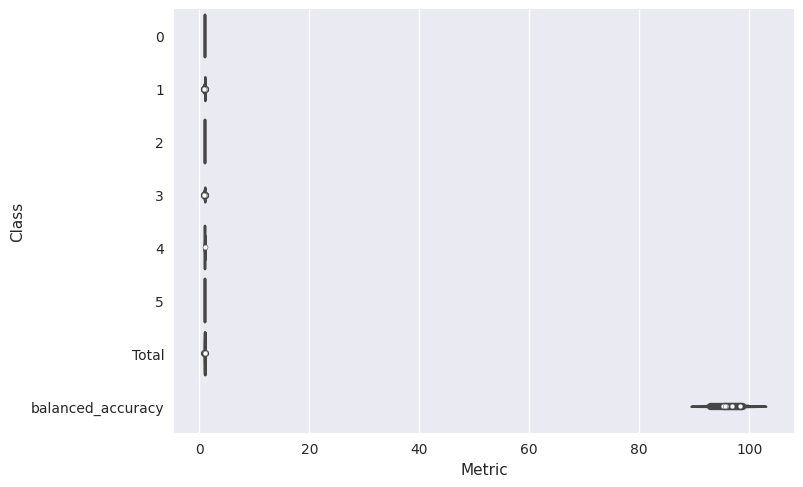

In [87]:
param_grid = {
    "epochs": pyhopper.choice([100, 150]),
    "masks_no": pyhopper.choice([10, 20, 50, 100, 150, 200]),
    "mask_size": pyhopper.choice([5, 10, 15, 20, 25]),
    "target_size": pyhopper.choice([10, 50, 100]),
    "lr": pyhopper.choice([3e-4]),
    "batch_size": pyhopper.choice([16, 32, 64]),
}

hp_best_params = pyhopper_best_params(
    network_hp_fn, param_grid, data=(X_train, y_train), train_size=train_max_size, time="30m"
)
hp_best_params

In [88]:
epochs = hp_best_params['epochs']
masks_no = hp_best_params['masks_no']
mask_size = hp_best_params['mask_size']
target_size = hp_best_params['target_size']

model = network_hp_fn(epochs, masks_no, mask_size, target_size)()

In [89]:
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_score = model.predict_proba(X_test)
hyper_results = _summarize_results(y_pred, 
                                   y_score, 
                                   torch.from_numpy(y_test), 
                                   torch.from_numpy(np.unique(y)))
hyper_results = pd.DataFrame(hyper_results)

In [ ]:
res = hyper_results[hyper_results["Class"]=="Total"].reset_index(drop=True)["Metric"]
print(f"{eval_max_size}: {res.mean():.2f} ~ {res.std():.2f}, (max: {res.max():.2f})")

In [ ]:
with open(DATA+".txt", "w") as f:
    f.write(f"{eval_max_size}: {res.mean():.3f} ~ {res.std():.2f}, (max: {res.max():.3f})")

## Glass

In [ ]:
DATA = "Glass"

In [ ]:
dataset = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/glass/glass.data", header=None, na_values="?").dropna()
X = dataset.values[:, :-1].astype(float)
y = dataset.values[:, -1].astype(int)
y = LabelEncoder().fit_transform(y).astype(int)

In [ ]:
n_classes = len(np.unique(y if not isinstance(y, tuple) else y_train))
n_features = X.shape[1] if not isinstance(X, tuple) else X_train.shape[1]
unique, counts = np.unique(y if not isinstance(y, tuple) else y_train, return_counts=True)

print(dict(zip(unique, counts)))

print('n_classes', n_classes)
print('n_features', n_features)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split_tuple(X, y, train_size=0.8)

eval_max_size = int(len(X_train))
train_max_size = int(len(X_train) * 0.75)
print('train_max_size', train_max_size)
print('eval_max_size', eval_max_size)

In [ ]:
def network_hp_fn(epochs=150, masks_no=100, mask_size=100, target_size=100, lr=3e-4, batch_size=64, verbose=False):
    def _inner():
        hypernet = Hypernetwork(
                        target_architecture=[(mask_size, target_size), (target_size, n_classes)],
                        test_nodes=masks_no,
                        architecture=torch.nn.Sequential(torch.nn.Linear(n_features, 64), 
                            torch.nn.ReLU(),
                            torch.nn.Linear(64, 128),
                            torch.nn.ReLU(),
                            torch.nn.Dropout(),
                            torch.nn.Linear(128, 128),
                            torch.nn.ReLU(),
                        ),
                        mode=TrainingModes.CARTHESIAN,
                    ).to(DEVICE)    
        hypernet = hypernet.train()

        network = HypernetworkSklearnInterface(hypernet, device=DEVICE, epochs=epochs, batch_size=batch_size, verbose=verbose, lr=lr)
        return network
    return _inner


In [ ]:
param_grid = {
    "epochs": pyhopper.choice([100]),
    "masks_no": pyhopper.choice([5, 10, 50, 70, 100, 150, 200]),
    "mask_size": pyhopper.choice([2, 5, 10, 20, 50, 90]),
    "target_size": pyhopper.choice([5, 10, 20, 50]),
    "lr": pyhopper.choice([3e-5, 3e-4, 3e-3, 3e-2, 3e-1]),
    "batch_size": pyhopper.choice([32, 64]),
}

hp_best_params = pyhopper_best_params(
    network_hp_fn, param_grid, data=(X_train, y_train), train_size=train_max_size, time="300m"
)
hp_best_params

In [ ]:
epochs = hp_best_params['epochs']
masks_no = hp_best_params['masks_no']
mask_size = hp_best_params['mask_size']
target_size = hp_best_params['target_size']

model = network_hp_fn(epochs, masks_no, mask_size, target_size, verbose=True)()

In [ ]:
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_score = model.predict_proba(X_test)
hyper_results = _summarize_results(y_pred, 
                                   y_score, 
                                   torch.from_numpy(y_test), 
                                   torch.from_numpy(np.unique(y)))
hyper_results = pd.DataFrame(hyper_results)

In [ ]:
res = hyper_results[hyper_results["Class"]=="Total"].reset_index(drop=True)["Metric"]
print(f"{eval_max_size}: {res.mean():.2f} ~ {res.std():.2f}, (max: {res.max():.2f})")

In [ ]:
with open(DATA+".txt", "w") as f:
    f.write(f"{eval_max_size}: {res.mean():.3f} ~ {res.std():.2f}, (max: {res.max():.3f})")

## Cleveland

In [ ]:
DATA = "Cleveland"

In [ ]:
dataset = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data", header=None, na_values="?").dropna()
X = dataset.values[:, :-1].astype(float)
y = dataset.values[:, -1].astype(int)
y = LabelEncoder().fit_transform(y).astype(int)

In [ ]:
n_classes = len(np.unique(y if not isinstance(y, tuple) else y_train))
n_features = X.shape[1] if not isinstance(X, tuple) else X_train.shape[1]
unique, counts = np.unique(y if not isinstance(y, tuple) else y_train, return_counts=True)

print(dict(zip(unique, counts)))

print('n_classes', n_classes)
print('n_features', n_features)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split_tuple(X, y, train_size=0.8)

eval_max_size = int(len(X_train))
train_max_size = int(len(X_train) * 0.75)
print('train_max_size', train_max_size)
print('eval_max_size', eval_max_size)

In [ ]:
def network_hp_fn(epochs=150, masks_no=100, mask_size=100, target_size=100, lr=3e-4, batch_size=64, verbose=False):
    def _inner():
        hypernet = Hypernetwork(
                        target_architecture=[(mask_size, target_size), (target_size, n_classes)],
                        test_nodes=masks_no,
                        architecture=torch.nn.Sequential(torch.nn.Linear(n_features, 64), 
                            torch.nn.ReLU(),
                            torch.nn.Linear(64, 128),
                            torch.nn.ReLU(),
                            torch.nn.Dropout(),
                            torch.nn.Linear(128, 128),
                            torch.nn.ReLU(),
                        ),
                        mode=TrainingModes.CARTHESIAN,
                    ).to(DEVICE)    
        hypernet = hypernet.train()

        network = HypernetworkSklearnInterface(hypernet, device=DEVICE, epochs=epochs, batch_size=batch_size, verbose=verbose, lr=lr)
        return network
    return _inner


In [ ]:
param_grid = {
    "epochs": pyhopper.choice([100]),
    "masks_no": pyhopper.choice([5, 10, 50, 70, 100, 150, 200]),
    "mask_size": pyhopper.choice([2, 5, 10, 20, 50, 90]),
    "target_size": pyhopper.choice([5, 10, 20, 50]),
    "lr": pyhopper.choice([3e-5, 3e-4, 3e-3, 3e-2, 3e-1]),
    "batch_size": pyhopper.choice([32, 64]),
}

hp_best_params = pyhopper_best_params(
    network_hp_fn, param_grid, data=(X_train, y_train), train_size=train_max_size, time="300m"
)
hp_best_params

In [ ]:
epochs = hp_best_params['epochs']
masks_no = hp_best_params['masks_no']
mask_size = hp_best_params['mask_size']
target_size = hp_best_params['target_size']

model = network_hp_fn(epochs, masks_no, mask_size, target_size, verbose=True)()

In [ ]:
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_score = model.predict_proba(X_test)
hyper_results = _summarize_results(y_pred, 
                                   y_score, 
                                   torch.from_numpy(y_test), 
                                   torch.from_numpy(np.unique(y)))
hyper_results = pd.DataFrame(hyper_results)

In [ ]:
with open(DATA+".txt", "w") as f:
    f.write(f"{eval_max_size}: {res.mean():.3f} ~ {res.std():.2f}, (max: {res.max():.3f})")

# cnae

In [ ]:
DATA = "cnae"

In [ ]:
if DATA == "cnae":
    cnae = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00233/CNAE-9.data', header=None)
    cnae = cnae.drop(1, axis=1)
    X = cnae.values[:, 1:].astype(float)
    y = cnae.values[:, 0]
    y = LabelEncoder().fit_transform(y).astype(int)
    #(1080, 855) 2

print(X.shape, len(np.unique(y)))

In [ ]:
n_classes = len(np.unique(y))
n_features = X.shape[1]
unique, counts = np.unique(y, return_counts=True)

print(dict(zip(unique, counts)))

print('n_classes', n_classes)
print('n_features', n_features)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y)

eval_max_size = int(len(X_train))
train_max_size = int(len(X_train) * 0.75)
print('train_max_size', train_max_size)
print('eval_max_size', eval_max_size)

In [ ]:
def network_hp_fn(epochs=150, masks_no=100, mask_size=100, target_size=100, lr=3e-4, batch_size=64, verbose=False):
    def _inner():
        hypernet = Hypernetwork(
                        target_architecture=[(mask_size, target_size), (target_size, n_classes)],
                        test_nodes=masks_no,
                        architecture=torch.nn.Sequential(torch.nn.Linear(n_features, 64), 
                            torch.nn.ReLU(),
                            torch.nn.Linear(64, 128),
                            torch.nn.ReLU(),
                            torch.nn.Dropout(),
                            torch.nn.Linear(128, 128),
                            torch.nn.ReLU(),
                        ),
                        mode=TrainingModes.CARTHESIAN,
                    ).to(DEVICE)    
        hypernet = hypernet.train()

        network = HypernetworkSklearnInterface(hypernet, device=DEVICE, epochs=epochs, batch_size=batch_size, verbose=verbose, lr=lr)
        return network
    return _inner


In [ ]:
param_grid = {
    "epochs": pyhopper.choice([100]),
    "masks_no": pyhopper.choice([3, 5, 10, 50, 75, 100, 150]),
    "mask_size": pyhopper.choice([5, 10, 20, 50, 100, 200, 400, 600, 750]),
    "target_size": pyhopper.choice([5, 10, 20, 50]),
    "lr": pyhopper.choice([3e-5, 3e-4, 3e-3, 3e-2, 3e-1]),
    "batch_size": pyhopper.choice([64]),
}

hp_best_params = pyhopper_best_params(
    network_hp_fn, param_grid, data=(X_train, y_train), train_size=train_max_size, time="480m"
)
hp_best_params

In [ ]:
epochs = 100#hp_best_params['epochs']
masks_no = hp_best_params['masks_no']
mask_size = hp_best_params['mask_size']
target_size = hp_best_params['target_size']
batch_size = hp_best_params['batch_size']
lr = hp_best_params['lr']


hyper_results = test_model(network_hp_fn(epochs, masks_no, mask_size, target_size, batch_size=batch_size,verbose=True),
                    (X, y),
                    eval_max_size,
                    None, 10)

In [ ]:
res = hyper_results[hyper_results["Class"]=="Total"].reset_index(drop=True)["Metric"]
print(f"{eval_max_size}: {res.mean():.2f} ~ {res.std():.2f}, (max: {res.max():.2f})")

In [ ]:
d[DATA] = hyper_results.groupby("Class")['Metric'].agg(['mean', 'std', 'max'])

In [ ]:
d